마켓켑과 볼륨이 얼마나 상관성이 높을지?

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm

from tools_ryu import mytool
from multi_run_v3.data_pp import DataPreprocess

In [2]:
data = pd.read_pickle("Data/cmktcap_data_final.pickle")

data_pp = DataPreprocess()
data_pp.initialize(data=data)
data_pp.make_mask(mktcap_thresh=1_000_000,
                  vol_thresh=1_000_000,
                  ma=True)

<AxesSubplot:xlabel='date'>

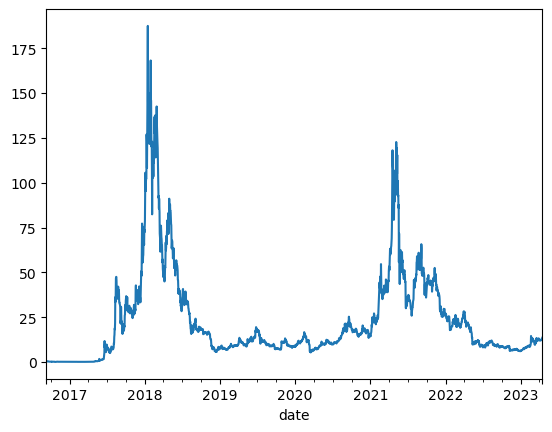

In [22]:
data_pp.price_df.loc[:, '1376'].dropna().plot() # 11857 / 1376

In [94]:
start_from = '2017-12'
mktcap = data_pp.mktcap_df.loc[start_from:]
vol = data_pp.vol_df.loc[start_from:]
mask = data_pp.mask.loc[start_from:]

In [95]:
mktcap = (mktcap * mask)#.resample('W').mean()
vol = (vol * mask)#.resample('W').mean()

In [96]:
mktcap_rank = mktcap.rank(1)
vol_rank = vol.rank(1)

n_group = 5

In [97]:
coin_count = mktcap_rank.count(axis=1)  
rank_thresh = coin_count.apply(lambda x: [i for i in range(0, x, x//n_group)])

# rank 기반으로 그룹을 나눈다    
mktcap_mask = {}    

for i in range(1, n_group+1):
    if i == 1: # 처음
        thresh = rank_thresh.apply(lambda x: x[i])  
        group_rank =  mktcap_rank.apply(lambda x: x <= thresh, axis=0)
    elif i == n_group: # 마지막
        thresh = rank_thresh.apply(lambda x: x[i-1])
        group_rank = mktcap_rank.apply(lambda x: thresh < x, axis=0)
    else:
        thresh = rank_thresh.apply(lambda x: x[i])
        thresh_1 = rank_thresh.apply(lambda x: x[i-1]) # 뒤에거를 가져와야함
        group_rank = mktcap_rank.apply(lambda x: (thresh_1 < x) & (x <= thresh), axis=0)
        
    group_mask = np.where(group_rank == True, 1, np.nan) # 속도 개선을 위해 replace()를 np.where로 수정 (2023-05-15 Edited)
    group_mask = pd.DataFrame(group_mask, index=mktcap_rank.index, columns=mktcap_rank.columns)
    mktcap_mask[f"Q{i}"] = group_mask

In [98]:
# rank 기반으로 그룹을 나눈다    
vol_mask = {}    

for i in range(1, n_group+1):
    if i == 1: # 처음
        thresh = rank_thresh.apply(lambda x: x[i])  
        group_rank =  vol_rank.apply(lambda x: x <= thresh, axis=0)
    elif i == n_group: # 마지막
        thresh = rank_thresh.apply(lambda x: x[i-1])
        group_rank = vol_rank.apply(lambda x: thresh < x, axis=0)
    else:
        thresh = rank_thresh.apply(lambda x: x[i])
        thresh_1 = rank_thresh.apply(lambda x: x[i-1]) # 뒤에거를 가져와야함
        group_rank = vol_rank.apply(lambda x: (thresh_1 < x) & (x <= thresh), axis=0)
        
    group_mask = np.where(group_rank == True, 1, np.nan) # 속도 개선을 위해 replace()를 np.where로 수정 (2023-05-15 Edited)
    group_mask = pd.DataFrame(group_mask, index=vol_rank.index, columns=vol_rank.columns)
    vol_mask[f"Q{i}"] = group_mask

In [142]:
mktcap_group = ((mktcap_mask['Q1'].fillna(0) * 1) + (mktcap_mask['Q2'].fillna(0) * 2) + (mktcap_mask['Q3'].fillna(0) * 3) + (mktcap_mask['Q4'].fillna(0) * 4) + (mktcap_mask['Q5'].fillna(0) * 5)).replace(0, np.nan).dropna(thresh=1, axis=1).fillna(0)
vol_group = ((vol_mask['Q1'].fillna(0) * 1) + (vol_mask['Q2'].fillna(0) * 2) + (vol_mask['Q3'].fillna(0) * 3) + (vol_mask['Q4'].fillna(0) * 4) + (vol_mask['Q5'].fillna(0) * 5)).replace(0, np.nan).dropna(thresh=1, axis=1).fillna(0)

In [143]:
# Use `stack` to transform DataFrames into Series with MultiIndex
mktcap_series = mktcap_group.stack()
vol_series = vol_group.stack()

# Create a new DataFrame by concatenating the two series side-by-side
combined_df = pd.concat([mktcap_series, vol_series], axis=1)
combined_df.columns = ['mktcap', 'vol']

# Use `groupby` to count occurrences of each combination
result_series = combined_df.groupby(['mktcap', 'vol']).size()

# Unstack the result to transform it back to a matrix form
result_matrix = result_series.unstack(fill_value=0)

# If necessary, reindex the result to ensure the same shape as the original matrix
result_matrix = result_matrix.reindex(index=[0, 1, 2, 3,4,5], columns=[0, 1, 2, 3,4,5], fill_value=0)


In [153]:
res_matrix_sample = result_matrix.iloc[1:,1:]

mktcap_q4 = res_matrix_sample.loc[4,:]
volume_q4 = res_matrix_sample.loc[:, 4]

mktcap_q5 = res_matrix_sample.loc[5,:]
volume_q5 = res_matrix_sample.loc[:, 5]

volume_q4_prob = volume_q4 / np.sum(res_matrix_sample.values)
mktcap_q4_prob = mktcap_q4 / np.sum(res_matrix_sample.values)

volume_q5_prob = volume_q5 / np.sum(res_matrix_sample.values)
mktcap_q5_prob = mktcap_q5 / np.sum(res_matrix_sample.values)

In [161]:
pd.concat([mktcap_q5_prob, volume_q5_prob], axis=1, keys=['mktcap Q5', 'volume Q5']).iloc[:4].sum()

mktcap Q5    0.061878
volume Q5    0.061878
dtype: float64

In [163]:
0.061878 + 0.045750, 0.061878 + 0.040732

(0.107628, 0.10261)

In [162]:
pd.concat([mktcap_q4_prob, volume_q4_prob], axis=1, keys=['mktcap Q4', 'volume Q4']).iloc[:2].sum()

mktcap Q4    0.045750
volume Q4    0.040732
dtype: float64